In [1]:
# Main Setup

# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.70

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
# print(mem_rec.size())

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

# print(f"Training loss: {loss_val.item():.3f}")
# print_batch_accuracy(data, targets, train=True)

# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

# print(f"Training loss: {loss_val.item():.3f}")
# print_batch_accuracy(data, targets, train=True)

In [2]:
# Training Loop 
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 55.13
Test Set Loss: 53.38
Train set accuracy for a single minibatch: 10.16%
Test set accuracy for a single minibatch: 7.03%


Epoch 0, Iteration 50
Train Set Loss: 15.68
Test Set Loss: 13.66
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 10.35
Test Set Loss: 8.07
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 150
Train Set Loss: 5.77
Test Set Loss: 9.64
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 200
Train Set Loss: 7.61
Test Set Loss: 6.51
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 5.02
Test Set Loss: 6.46
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 89.84%


Epoch 0, 

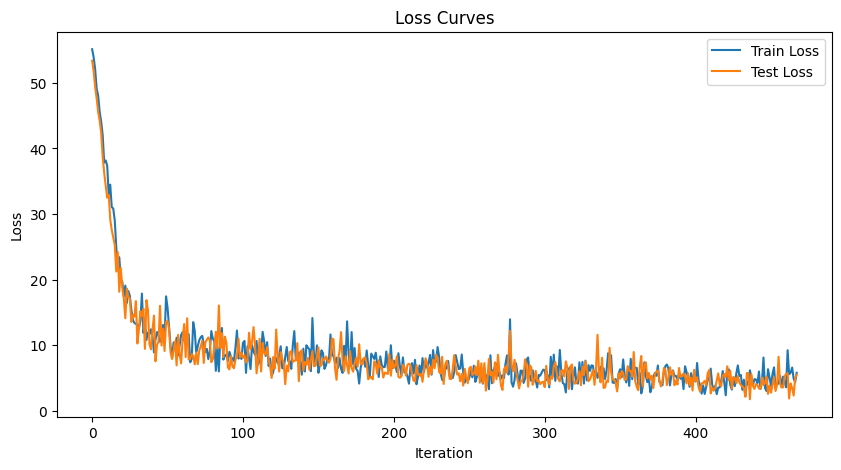

In [3]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [4]:
# Initial Evaluation

# Test Accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9381/10000
Test Set Accuracy: 93.81%


In [5]:
# Save Ref Network
torch.save(net.state_dict(), 'ref_snn.pth')

In [6]:
# Testing Setup

test_net = Net()

test_net.load_state_dict(torch.load('ref_snn.pth'))

test_net.to(device)


print("Testing Loaded Network")


def acc_test(net, mnist_test, batch_size):
    # Test Accuracy

    total = 0
    correct = 0

    # drop_last switched to False to keep all samples
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # forward pass
            test_spk, _ = net(data.view(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # print(f"Total correctly classified test set images: {correct}/{total}")
    # print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
    return 100 * correct / total

def mod_fc1(net, neuron_index): # neuron_index 0 to 999
    # Print the initial weights
    # print("Initial weights:", net.fc1.weight)

    # Access the parameters
    parameters = net.parameters()

    # Assuming you want to modify the weights of the first neuron in the linear layer
    # neuron_index = 1    # 0 to 999
    for param in parameters:
        if param is net.fc1.weight:
            # Modify the weights of the first neuron
            new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
            param.data[neuron_index] = new_weights

    # Print the modified weights
    # print("Modified weights:", net.fc1.weight)
    # print("Size of Weights: ", net.fc1.weight.size())
    return net

def mod_fc2(net, neuron_index): # neuron_index 0 to 9
    # Print the initial weights
    # print("Initial weights:", net.fc2.weight)

    # Access the parameters
    parameters = net.parameters()

    # Assuming you want to modify the weights of the first neuron in the linear layer
    # neuron_index = 4     # 0 to 9
    for param in parameters:
        if param is net.fc2.weight:
            # Modify the weights of the first neuron
            new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
            param.data[neuron_index] = new_weights

    # Print the modified weights
    # print("Modified weights:", net.fc2.weight)
    # print("Size of Weights: ", net.fc2.weight.size())
    return net

Testing Loaded Network


In [7]:
# Output Layer Corruption

acc = acc_test(test_net, mnist_test, batch_size)
for x in range(0,10):
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn.pth'))
    test_net.to(device)
    acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
    print(f"Test Set Accuracy of Output Layer Parameter Corruption({x}): {acc:.2f}%")

Test Set Accuracy of Output Layer Parameter Corruption(0): 89.77%
Test Set Accuracy of Output Layer Parameter Corruption(1): 44.91%
Test Set Accuracy of Output Layer Parameter Corruption(2): 83.31%
Test Set Accuracy of Output Layer Parameter Corruption(3): 62.12%
Test Set Accuracy of Output Layer Parameter Corruption(4): 50.55%
Test Set Accuracy of Output Layer Parameter Corruption(5): 60.49%
Test Set Accuracy of Output Layer Parameter Corruption(6): 83.69%
Test Set Accuracy of Output Layer Parameter Corruption(7): 80.37%
Test Set Accuracy of Output Layer Parameter Corruption(8): 75.23%
Test Set Accuracy of Output Layer Parameter Corruption(9): 85.59%


In [8]:
# Hidden Layer Corruption

acc = acc_test(test_net, mnist_test, batch_size)
for x in range(0,1000):
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn.pth'))
    test_net.to(device)
    acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
    print(f"Test Set Accuracy of Hidden Layer Parameter Corruption({x}): {acc:.2f}%")

Test Set Accuracy of Hidden Layer Parameter Corruption(0): 93.86%
Test Set Accuracy of Hidden Layer Parameter Corruption(1): 93.74%
Test Set Accuracy of Hidden Layer Parameter Corruption(2): 93.87%
Test Set Accuracy of Hidden Layer Parameter Corruption(3): 93.83%
Test Set Accuracy of Hidden Layer Parameter Corruption(4): 93.83%
Test Set Accuracy of Hidden Layer Parameter Corruption(5): 93.84%
Test Set Accuracy of Hidden Layer Parameter Corruption(6): 93.74%
Test Set Accuracy of Hidden Layer Parameter Corruption(7): 93.77%
Test Set Accuracy of Hidden Layer Parameter Corruption(8): 93.80%
Test Set Accuracy of Hidden Layer Parameter Corruption(9): 93.85%
Test Set Accuracy of Hidden Layer Parameter Corruption(10): 93.76%
Test Set Accuracy of Hidden Layer Parameter Corruption(11): 93.84%
Test Set Accuracy of Hidden Layer Parameter Corruption(12): 93.81%
Test Set Accuracy of Hidden Layer Parameter Corruption(13): 93.84%
Test Set Accuracy of Hidden Layer Parameter Corruption(14): 93.80%
Test 

KeyboardInterrupt: 